# Project 4: Multi-factor Model
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.


### Load Packages

In [25]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import project_tests
import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


## Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
import os
import project_helper
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), 'data', 'module_4_quizzes_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Overwriting bundle with name 'FBA_bundle'
  


## Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [4]:
universe_end_date = pd.Timestamp('2022-02-08', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AA]),
 Equity(2 [AAL]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABNB]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ACWI]),
 Equity(9 [ADBE]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADSK]),
 Equity(13 [AEP]),
 Equity(14 [AFL]),
 Equity(15 [AFRM]),
 Equity(16 [AGG]),
 Equity(17 [AIG]),
 Equity(18 [AL]),
 Equity(19 [ALB]),
 Equity(20 [ALGN]),
 Equity(21 [ALL]),
 Equity(22 [AMAT]),
 Equity(23 [AMC]),
 Equity(24 [AMD]),
 Equity(25 [AMGN]),
 Equity(26 [AMT]),
 Equity(27 [AMZN]),
 Equity(28 [ANET]),
 Equity(29 [ANTM]),
 Equity(30 [APA]),
 Equity(31 [APD]),
 Equity(32 [APH]),
 Equity(33 [APO]),
 Equity(34 [APPS]),
 Equity(35 [APTV]),
 Equity(36 [ARKK]),
 Equity(37 [ASAN]),
 Equity(38 [ASML]),
 Equity(39 [ATER]),
 Equity(40 [ATVI]),
 Equity(41 [AVGO]),
 Equity(42 [AXP]),
 Equity(43 [AZN]),
 Equity(44 [AZO]),
 Equity(45 [BABA]),
 Equity(46 [BAC]),
 Equity(47 [BAX]),
 Equity(48 [BBIG]),
 Equity(49 [BBL]),
 Equity(50 [BBWI]),
 Equity(51 [BDX]),
 E

## Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [5]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [6]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

### View Data
Let's get returns data for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [7]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABNB]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ACWI]),Equity(9 [ADBE]),...,Equity(490 [XME]),Equity(491 [XOM]),Equity(492 [XOP]),Equity(493 [XPEV]),Equity(494 [YUM]),Equity(495 [ZBH]),Equity(496 [ZEN]),Equity(497 [ZIM]),Equity(498 [ZNGA]),Equity(499 [ZTS])
2017-02-10 00:00:00+00:00,-0.00218633,0.02354170,0.00323365,-0.00223957,-0.00689841,0.00000000,0.00472095,0.00529227,0.00407162,0.00352113,...,0.00555065,0.00830036,0.01127499,0.00000000,0.00904977,-0.00229716,-0.02330508,0.00000000,0.02380952,-0.00410107
2017-02-13 00:00:00+00:00,0.00318333,0.00468378,0.02067310,0.00885013,0.00148551,0.00000000,0.01122625,0.00841939,0.00469259,0.00684638,...,0.01455275,0.00581628,-0.00792587,0.00000000,0.00162198,0.00358651,-0.00831526,0.00000000,0.01937984,-0.01059960
2017-02-14 00:00:00+00:00,-0.00257567,0.00208355,-0.01772803,0.01296802,0.00513935,0.00000000,0.00994625,0.01189610,0.00209740,-0.00059499,...,-0.00200940,-0.00217232,0.00798920,0.00000000,0.00690608,-0.00484435,-0.01640540,0.00000000,0.02661597,-0.00216503
2017-02-15 00:00:00+00:00,0.02439780,-0.01790727,0.02084165,0.00363979,0.01363485,0.00000000,0.00800796,-0.00058422,0.00483678,0.00978057,...,-0.00517300,0.00410879,-0.00395962,0.00000000,0.00102486,0.00110836,0.02038547,0.00000000,-0.01111111,0.00235677
2017-02-16 00:00:00+00:00,-0.01510477,-0.03720856,-0.01198905,-0.00118802,-0.00274770,0.00000000,0.00456429,0.00658303,0.00015753,0.00168449,...,-0.00115207,-0.01033682,-0.01667388,0.00000000,-0.00307145,-0.00844080,-0.00908100,0.00000000,-0.01498127,-0.04297524
2017-02-17 00:00:00+00:00,0.01554118,-0.00687172,-0.00127501,0.00272318,0.00470864,0.00000000,0.01107645,0.00422597,-0.00064753,0.00622215,...,-0.00953895,-0.00655692,-0.00505854,0.00000000,-0.00058458,0.00473421,0.02236070,0.00000000,0.01901141,-0.00510861
2017-02-21 00:00:00+00:00,-0.00542372,0.01381085,-0.00213506,0.00724208,0.00096187,0.00000000,0.00716576,0.00717972,0.00432552,-0.00033425,...,0.00786832,0.00158405,0.01246223,0.00000000,-0.01067092,0.00256043,0.00394407,0.00000000,0.01119403,0.01826591
2017-02-22 00:00:00+00:00,-0.00020272,-0.00300300,-0.01047756,0.00297518,-0.00758536,0.00000000,0.00000000,0.00090100,0.00031386,-0.00133746,...,-0.01708147,-0.01172202,-0.02888642,0.00000000,-0.02320193,-0.00230560,0.00285714,0.00000000,0.04428044,-0.00167449
2017-02-23 00:00:00+00:00,0.00253457,-0.06229463,-0.00474811,-0.00420233,0.00943571,0.00000000,0.00865832,0.00220636,0.00048808,-0.00535699,...,-0.03952218,0.01049609,-0.00078223,0.00000000,-0.00528391,-0.00444409,-0.01246439,0.00000000,-0.04240283,0.00374019
2017-02-24 00:00:00+00:00,0.00525858,0.00467221,0.00389724,0.00093090,0.00242872,0.00000000,0.00616900,0.00775808,-0.00256115,0.00403938,...,-0.00737629,-0.00855497,-0.01966816,0.00000000,0.00304246,0.00464248,0.00685179,0.00000000,-0.00369004,0.00560859


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [8]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    #TODO: Implement function
    pca = PCA(n_components=num_factor_exposures,svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca


project_tests.test_fit_pca(fit_pca)

Tests Passed


### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [9]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[ 0.00134348, -0.00138895,  0.00376859, ...,  0.00027635,
         0.00097684,  0.00093886],
       [-0.03354367, -0.06474849, -0.05859058, ..., -0.00928044,
        -0.02604268, -0.03047748],
       [-0.01239896,  0.05525787,  0.07014353, ..., -0.01070269,
        -0.0391718 , -0.00892011],
       ...,
       [ 0.00573066,  0.08804614,  0.13573948, ...,  0.02882026,
        -0.01898848, -0.02817201],
       [ 0.00326833, -0.01257805, -0.10389081, ...,  0.02189137,
         0.00280743,  0.00262184],
       [-0.01924621,  0.01663676, -0.01524744, ..., -0.02512689,
         0.00609753, -0.00868365]])

Let's also look at the PCA's percent of variance explained by each factor

<BarContainer object of 20 artists>

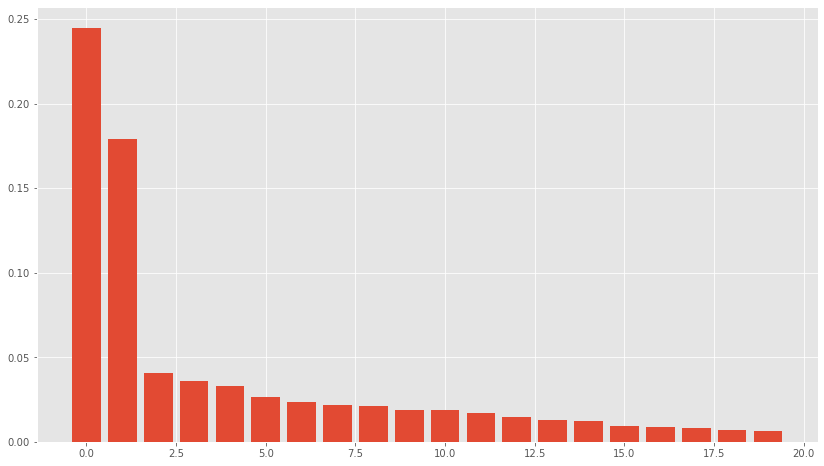

In [26]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [11]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    #TODO: Implement function
    
    return pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)


project_tests.test_factor_betas(factor_betas)

Tests Passed


### View Data
Let's view the factor betas from this model.

In [12]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),0.00134348,-0.03354367,-0.01239896,0.01352122,-0.01650602,-0.01247773,-0.00438704,0.00192520,0.00822670,-0.01277563,0.00470991,0.01019859,0.02072624,0.01599073,-0.00140714,-0.01968693,0.00607599,0.00573066,0.00326833,-0.01924621
Equity(1 [AA]),-0.00138895,-0.06474849,0.05525787,-0.03386218,0.02250890,0.01029798,0.01529780,-0.02067470,-0.02924924,0.00911965,-0.01238283,-0.00374718,-0.03681110,0.00689745,-0.03043861,-0.00089681,0.00164214,0.08804614,-0.01257805,0.01663676
Equity(2 [AAL]),0.00376859,-0.05859058,0.07014353,-0.05882995,0.01932498,0.02637494,0.02377551,-0.00728582,-0.00533011,0.02726494,-0.00235299,-0.00247951,-0.03447598,-0.08750268,0.09296938,-0.04395747,0.03883615,0.13573948,-0.10389081,-0.01524744
Equity(3 [AAPL]),0.00193180,-0.04018643,-0.02148063,0.01674490,-0.02155667,-0.00474838,-0.00152486,0.00650023,0.01435758,-0.01874326,0.00612911,0.00607502,0.03426776,0.01183668,-0.01110864,-0.00284723,-0.03146688,0.01972539,-0.00689300,0.01222513
Equity(4 [ABBV]),0.00151268,-0.02504694,0.00599324,0.00816877,-0.01798937,-0.02040603,-0.01114418,0.00639381,-0.00191036,-0.01061221,0.00309250,0.01251956,0.02312789,0.02260099,-0.00643417,-0.00727220,0.00020463,-0.02388285,-0.00346138,0.01598589
Equity(5 [ABNB]),0.00135216,-0.00886000,-0.02097344,-0.00767053,0.00997993,0.03556417,0.00952720,0.01068115,0.01179023,0.01906071,-0.01905927,-0.02636235,-0.00831420,-0.01171284,0.00812111,0.00005326,-0.01133344,0.00926935,0.02229226,-0.00699783
Equity(6 [ABT]),0.00125293,-0.02674359,-0.00859909,0.01784056,-0.02178840,-0.01321473,-0.01523245,-0.00176587,0.01753349,-0.01803508,0.01137402,0.01760934,0.03628575,0.02197803,-0.00112339,-0.03182004,0.00739147,-0.01030739,0.01181037,-0.00026211
Equity(7 [ACN]),0.00089814,-0.03580649,0.00644461,0.02000646,-0.01387108,-0.01252903,-0.01023218,-0.00091380,0.00507521,-0.00875879,0.00504406,0.01245920,0.02395959,0.00479419,0.00890100,-0.01468140,-0.00322369,-0.02549751,0.00797693,-0.01093675
Equity(8 [ACWI]),0.00115795,-0.03239784,0.00253840,0.00414081,-0.00859638,-0.00877066,-0.00048820,0.00100074,0.00428704,-0.00550021,0.00186932,0.00510488,0.01346312,0.00697112,0.00167347,-0.00703815,-0.00147121,0.00150191,0.00821110,-0.00830108
Equity(9 [ADBE]),0.00251647,-0.04235950,-0.04647430,0.02298285,-0.02995877,-0.00827181,-0.00294837,0.01143761,0.02356928,-0.02097481,0.01171683,0.01630706,0.01693012,-0.00504569,-0.01566145,0.00533589,-0.03622491,-0.02211560,-0.02199796,0.00570077


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [13]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    #TODO: Implement function
    
    return pd.DataFrame(pca.transform(returns),index=factor_return_indices, columns=factor_return_columns)


project_tests.test_factor_returns(factor_returns)

Tests Passed


### View Data
Let's see what these factor returns looks like over time.

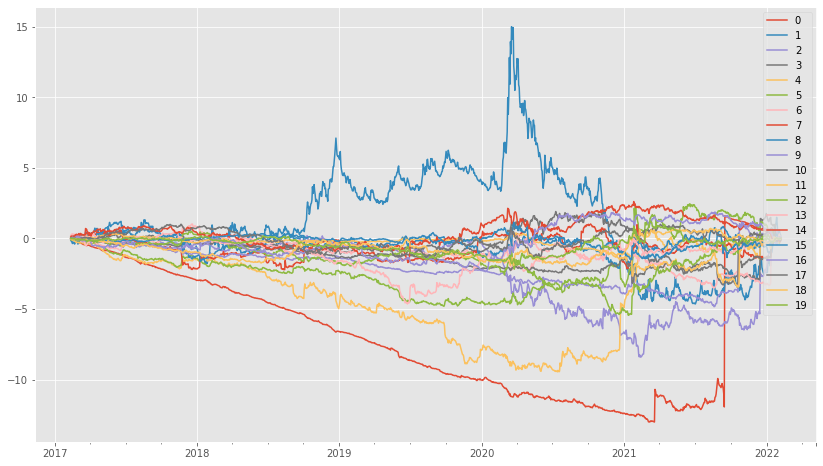

In [28]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)
plt.legend()

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [15]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    #TODO: Implement function
    
    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)


project_tests.test_factor_cov_matrix(factor_cov_matrix)

Tests Passed


### View Data

In [16]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[38.66601051,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 28.30847214,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  6.38935898,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  5.64352032,  0.        ,
         0.        ,  0.        ,  0.        ,  

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

You need to use only the diagonal of 'idiosyncratic_var_matrix' pandas dataframes and put it as a vector into 'idiosyncratic_var_vector' pandas series. Also use returns column name as index of the 'idiosyncratic_var_vector' pandas series.

In [17]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """

    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    residuals_ = (returns - common_returns_)

    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)


project_tests.test_idiosyncratic_var_matrix(idiosyncratic_var_matrix)

Tests Passed


### View Data

In [18]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], 252)

risk_model['idiosyncratic_var_matrix']

,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABNB]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ACWI]),Equity(9 [ADBE]),...,Equity(490 [XME]),Equity(491 [XOM]),Equity(492 [XOP]),Equity(493 [XPEV]),Equity(494 [YUM]),Equity(495 [ZBH]),Equity(496 [ZEN]),Equity(497 [ZIM]),Equity(498 [ZNGA]),Equity(499 [ZTS])
Equity(0 [A]),0.02845818,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AA]),0.00000000,0.14667529,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAL]),0.00000000,0.00000000,0.10469329,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.03359451,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.05144778,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(5 [ABNB]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.05118584,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(6 [ABT]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02668878,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(7 [ACN]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.01987529,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(8 [ACWI]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00119737,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(9 [ADBE]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03022572,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [19]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    #TODO: Implement function
    # 대각행렬 2번

    return pd.DataFrame(np.diag(idiosyncratic_var_matrix),returns.columns)


project_tests.test_idiosyncratic_var_vector(idiosyncratic_var_vector)

Tests Passed


### View Data

In [20]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.02845818
Equity(1 [AA]),0.14667529
Equity(2 [AAL]),0.10469329
Equity(3 [AAPL]),0.03359451
Equity(4 [ABBV]),0.05144778
Equity(5 [ABNB]),0.05118584
Equity(6 [ABT]),0.02668878
Equity(7 [ACN]),0.01987529
Equity(8 [ACWI]),0.00119737
Equity(9 [ADBE]),0.03022572


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [21]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function

    var_portfolio = weights.T.dot(factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix).dot(weights)

    return np.sqrt(var_portfolio[0][0])


project_tests.test_predict_portfolio_risk(predict_portfolio_risk)

Tests Passed


### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [22]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.1912570680603387

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [23]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [24]:
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.utils.math_utils import nanmean
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import CustomFactor


class Reversion(CustomFactor):
    """
    Here we define a basic mean reversion factor using a CustomFactor. We
    take a ratio of the last close price to the average price over the
    last 60 days. A high ratio indicates a high price relative to the mean
    and a low ratio indicates a low price relative to the mean.
    """
    inputs = [USEquityPricing.close]
    window_length = 5

    def compute(self, today, assets, out, prices):
        out[:] = -prices[-1] / np.mean(prices, axis=0)

def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    #TODO: Implement function

    factor = (
        Reversion(window_length=window_length, mask=universe).demean(groupby=sector).rank().zscore()
    )
    return factor


project_tests.test_mean_reversion_5day_sector_neutral(mean_reversion_5day_sector_neutral)


Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2016-01-07', tz='utc')
> end_date = pd.Timestamp('2016-01-11', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral')
> engine.run_pipeline(pipeline, start_dat, end_date)



AssertionError: Wrong value for run_pipeline.

INPUT pipeline:
<zipline.pipeline.pipeline.Pipeline object at 0x000001F102469708>

INPUT start_date:
2016-01-07 00:00:00+00:00

INPUT end_date:
2016-01-11 00:00:00+00:00

OUTPUT pipline_out:
                                              Mean_Reversion_5Day_Sector_Neutral
2016-01-07 00:00:00+00:00 Equity(3 [AAPL])                           -1.34164079
                          Equity(27 [AMZN])                          -0.44721360
                          Equity(231 [IWM])                           0.44721360
                          Equity(335 [PL])                            1.34164079
2016-01-08 00:00:00+00:00 Equity(3 [AAPL])                           -1.34164079
                          Equity(231 [IWM])                          -0.44721360
                          Equity(298 [NFLX])                          0.44721360
                          Equity(335 [PL])                            1.34164079
2016-01-11 00:00:00+00:00 Equity(3 [AAPL])                           -1.34164079
                          Equity(27 [AMZN])                          -0.44721360
                          Equity(231 [IWM])                           0.44721360
                          Equity(335 [PL])                            1.34164079

EXPECTED OUTPUT FOR pipline_out:
                                              Mean_Reversion_5Day_Sector_Neutral
2016-01-07 00:00:00+00:00 Equity(3 [AAPL])                            1.34164079
                          Equity(27 [AMZN])                           0.44721360
                          Equity(231 [IWM])                          -1.34164079
                          Equity(335 [PL])                           -0.44721360
2016-01-08 00:00:00+00:00 Equity(3 [AAPL])                            1.34164079
                          Equity(231 [IWM])                           0.44721360
                          Equity(298 [NFLX])                         -1.34164079
                          Equity(335 [PL])                           -0.44721360
2016-01-11 00:00:00+00:00 Equity(3 [AAPL])                           -1.34164079
                          Equity(27 [AMZN])                           0.44721360
                          Equity(231 [IWM])                           1.34164079
                          Equity(335 [PL])                           -0.44721360


### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [29]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral
2020-02-06 00:00:00+00:00 Equity(0 [A])                               0.23736939
                          Equity(1 [AA])                             -1.69125691
                          Equity(2 [AAL])                            -1.48355870
                          Equity(3 [AAPL])                           -0.15577366
                          Equity(4 [ABBV])                           -1.26844269
                          Equity(6 [ABT])                             0.38572526
                          Equity(7 [ACN])                            -0.02225338
                          Equity(8 [ACWI])                            0.09643132
                          Equity(9 [ADBE])                           -0.21511601
                          Equity(10 [ADM])                            0.05192455
                          Equity(11 [ADP])                           -0.58600569
                          Equity(12 [ADSK])                          -0.02967117
                          Equity(13 [AEP])                            1.46130532
                          Equity(14 [AFL])                           -0.23736939
                          Equity(16 [AGG])                            1.12008682
                          Equity(17 [AIG])                           -0.77886832
                          Equity(18 [AL])                            -1.45388752
                          Equity(19 [ALB])                           -1.32036724
                          Equity(20 [ALGN])                          -1.03107329
                          Equity(21 [ALL])                           -1.16459358
                          Equity(22 [AMAT])                          -1.50581208
                          Equity(23 [AMC])                           -1.39454518
                          Equity(24 [AMD])                           -0.81595728
                          Equity(25 [AMGN])                          -1.29069607
                          Equity(26 [AMT])                            0.41539644
                          Equity(27 [AMZN])                          -0.68985479
                          Equity(28 [ANET])                           0.54149892
                          Equity(29 [ANTM])                          -1.56515443
                          Equity(30 [APA])                           -0.47473878
                          Equity(31 [APD])                           -0.66760141
...                                                                          ...
2022-02-08 00:00:00+00:00 Equity(470 [WFC])                          -1.40296396
                          Equity(471 [WLTW])                         -0.19052597
                          Equity(472 [WMB])                          -0.24595171
                          Equity(473 [WMT])                           0.86949124
                          Equity(474 [WOLF])                          1.25054318
                          Equity(475 [WORK])                         -0.32909031
                          Equity(476 [WY])                            0.70321403
                          Equity(477 [WYNN])                         -1.43760505
                          Equity(478 [XBI])                          -1.00805559
                          Equity(479 [XHB])                           1.15354814
                          Equity(480 [XLB])                           1.14661993
                          Equity(481 [XLE])                          -1.18126101
                          Equity(482 [XLF])                          -0.91106055
                          Equity(483 [XLI])                           0.59236256
                          Equity(484 [XLK])                           0.71014225
                          Equity(485 [XLNX])                         -1.35446644
                          Equity(486 [XLP])                           0.48843930
                          Equity(487 [XLRE])                          0.39837

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [30]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """

    unsmoothed_factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    
    return SimpleMovingAverage(inputs=[unsmoothed_factor],
                               window_length=window_length).rank().zscore()


project_tests.test_mean_reversion_5day_sector_neutral_smoothed(mean_reversion_5day_sector_neutral_smoothed)

Running Integration Test on pipeline:
> start_dat = pd.Timestamp('2016-01-07', tz='utc')
> end_date = pd.Timestamp('2016-01-11', tz='utc')
> universe = AverageDollarVolume(window_length=2).top(4)
> factor = mean_reversion_5day_sector_neutral_smoothed(
    window_length=3,
    universe=universe,
    sector=project_helper.Sector())
> pipeline.add(factor, 'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
> engine.run_pipeline(pipeline, start_dat, end_date)



AssertionError: Wrong value for run_pipeline.

INPUT pipeline:
<zipline.pipeline.pipeline.Pipeline object at 0x000001F16E070708>

INPUT start_date:
2016-01-14 00:00:00+00:00

INPUT end_date:
2016-01-19 00:00:00+00:00

OUTPUT pipline_out:
                                             Mean_Reversion_5Day_Sector_Neutral_Smoothed
2016-01-14 00:00:00+00:00 Equity(3 [AAPL])                                   -1.34164079
                          Equity(27 [AMZN])                                  -0.44721360
                          Equity(231 [IWM])                                   0.44721360
                          Equity(335 [PL])                                    1.34164079
2016-01-15 00:00:00+00:00 Equity(3 [AAPL])                                   -1.34164079
                          Equity(27 [AMZN])                                  -0.44721360
                          Equity(231 [IWM])                                   0.44721360
                          Equity(335 [PL])                                    1.34164079
2016-01-19 00:00:00+00:00 Equity(3 [AAPL])                                   -1.34164079
                          Equity(27 [AMZN])                                  -0.44721360
                          Equity(231 [IWM])                                   0.44721360
                          Equity(335 [PL])                                    1.34164079

EXPECTED OUTPUT FOR pipline_out:
                                             Mean_Reversion_5Day_Sector_Neutral_Smoothed
2016-01-14 00:00:00+00:00 Equity(3 [AAPL])                                    0.44721360
                          Equity(27 [AMZN])                                   1.34164079
                          Equity(231 [IWM])                                  -1.34164079
                          Equity(335 [PL])                                   -0.44721360
2016-01-15 00:00:00+00:00 Equity(3 [AAPL])                                    1.34164079
                          Equity(27 [AMZN])                                   0.44721360
                          Equity(231 [IWM])                                  -1.34164079
                          Equity(335 [PL])                                   -0.44721360
2016-01-19 00:00:00+00:00 Equity(3 [AAPL])                                    0.44721360
                          Equity(27 [AMZN])                                   1.34164079
                          Equity(231 [IWM])                                  -1.34164079
                          Equity(335 [PL])                                   -0.44721360


### View Data
Let's see what some of the smoothed data looks like.

In [31]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2020-02-06 00:00:00+00:00 Equity(0 [A])                                        1.55773663
                          Equity(1 [AA])                                       0.79370390
                          Equity(2 [AAL])                                     -1.68383912
                          Equity(3 [AAPL])                                     0.61567686
                          Equity(4 [ABBV])                                    -0.68985479
                          Equity(6 [ABT])                                      0.95689536
                          Equity(7 [ACN])                                     -0.46732099
                          Equity(8 [ACWI])                                    -0.04450676
                          Equity(9 [ADBE])                                    -1.43163414
                          Equity(10 [ADM])                                    -1.37970959
                          Equity(11 [ADP])                                    -0.05192455
                          Equity(12 [ADSK])                                   -1.22393592
                          Equity(13 [AEP])                                    -0.67501921
                          Equity(14 [AFL])                                    -0.00741779
                          Equity(16 [AGG])                                    -0.25962277
                          Equity(17 [AIG])                                    -1.09783344
                          Equity(18 [AL])                                     -1.49839428
                          Equity(19 [ALB])                                    -1.66900353
                          Equity(20 [ALGN])                                    0.98656653
                          Equity(21 [ALL])                                    -1.47614090
                          Equity(22 [AMAT])                                   -1.02365550
                          Equity(23 [AMC])                                     0.25220498
                          Equity(24 [AMD])                                     0.40797864
                          Equity(25 [AMGN])                                    0.42281423
                          Equity(26 [AMT])                                     0.89013522
                          Equity(27 [AMZN])                                   -1.67642133
                          Equity(28 [ANET])                                    1.46872311
                          Equity(29 [ANTM])                                    0.77886832
                          Equity(30 [APA])                                     0.48957437
                          Equity(31 [APD])                                    -1.40938076
...                                                                                   ...
2022-02-08 00:00:00+00:00 Equity(470 [WFC])                                   -1.40296396
                          Equity(471 [WLTW])                                   0.82792194
                          Equity(472 [WMB])                                   -0.62007543
                          Equity(473 [WMT])                                    0.48843930
                          Equity(474 [WOLF])                                   1.19511745
                          Equity(475 [WORK])                                   0.41222892
                          Equity(476 [WY])                                     0.52308039
                          Equity(477 [WYNN])                                  -0.77249621
                          Equity(478 [XBI])                                    0.44687000
                          Equity(479 [XHB])                                    1.18818923
                          Equity(480 [XLB])                                    0.92491698
                          Equity(481 [XLE])                                   -1.51381543
                          Equity(482 [XLF])                                   -1.18126

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [32]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [33]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [34]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2020-02-06 00:00:00+00:00 Equity(0 [A])                             0.23736939   
                          Equity(1 [AA])                           -1.69125691   
                          Equity(2 [AAL])                          -1.48355870   
                          Equity(3 [AAPL])                         -0.15577366   
                          Equity(4 [ABBV])                         -1.26844269   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2020-02-06 00:00:00+00:00 Equity(0 [A])                                      1.55773663   
                          Equity(1 [AA])                                     0.79370390   
                          Equity(2 [AAL])                                   -1.68383912   
                          Equity(3 [AAPL])                                   0.61567686   
                          Equity(4 [ABBV])                                  -0.68985479   

                                            Momentum_1YR  Overnight_Sentiment  \
2020-02-06 00:00:00+00:00 Equity(0 [A])      -0.93771218          -1.24722747   
                          Equity(1 [AA])     -1.66618280           0.92154196   
                          Equity(2 [AAL])    -1.48019030           0.27757288   
                          Equity(3 [AAPL])    1.54218780          -1.23242358   
                          Equity(4 [ABBV])   -0.67422281           0.14433790   

                                            Overnight_Sentiment_Smoothed  
2020-02-06 00:00:00+00:00 Equity(0 [A])                      -1.53590326  
                          Equity(1 [AA])                     -1.04737499  
                          Equity(2 [AAL])                    -1.31384496  
                          Equity(3 [AAPL])                   -0.32198454  
                          Equity(4 [ABBV])                    1.20281581

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [35]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [36]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.5% entries from factor data: 4.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

<AxesSubplot:xlabel='date'>

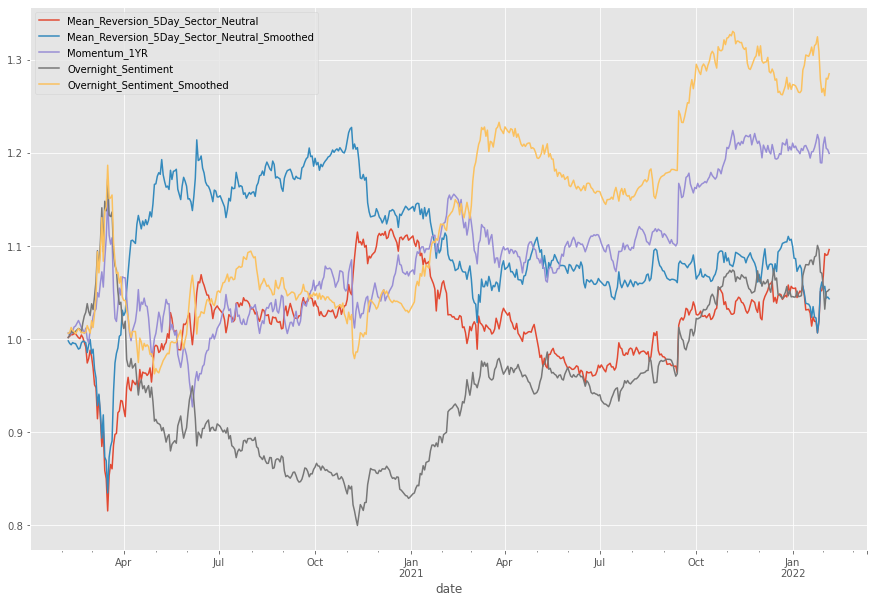

In [37]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot(figsize=(15,10))

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\pandas\

array([[<AxesSubplot:title={'center':'Mean_Reversion_5Day_Sector_Neutral'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'Mean_Reversion_5Day_Sector_Neutral_Smoothed'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'Momentum_1YR'}, xlabel='factor_quantile'>,
        <AxesSubplot:title={'center':'Overnight_Sentiment'}, xlabel='factor_quantile'>],
       [<AxesSubplot:title={'center':'Overnight_Sentiment_Smoothed'}, xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>],
       [<AxesSubplot:xlabel='factor_quantile'>,
        <AxesSubplot:xlabel='factor_quantile'>]], dtype=object)

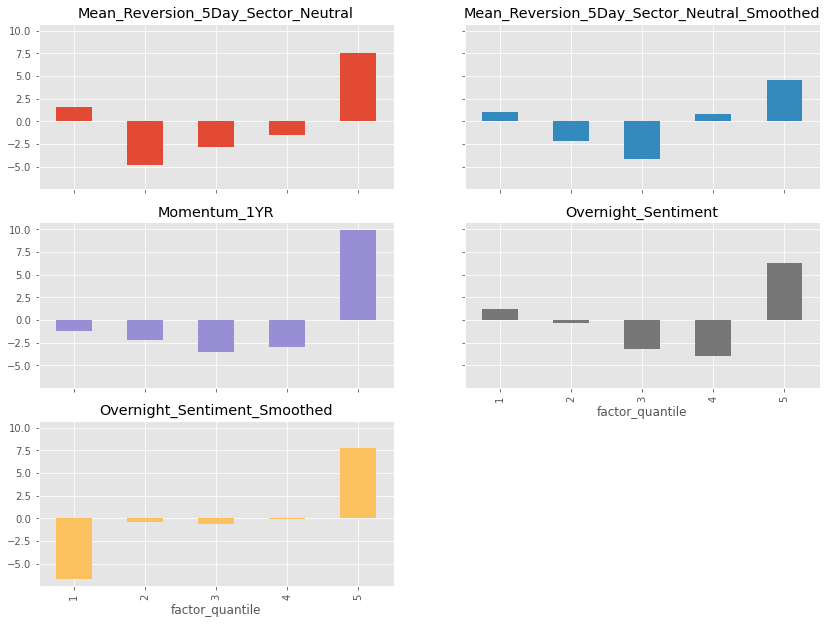

In [38]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

<AxesSubplot:title={'center':'Factor Rank Autocorrelation'}, xlabel='date'>

<Figure size 1080x720 with 0 Axes>

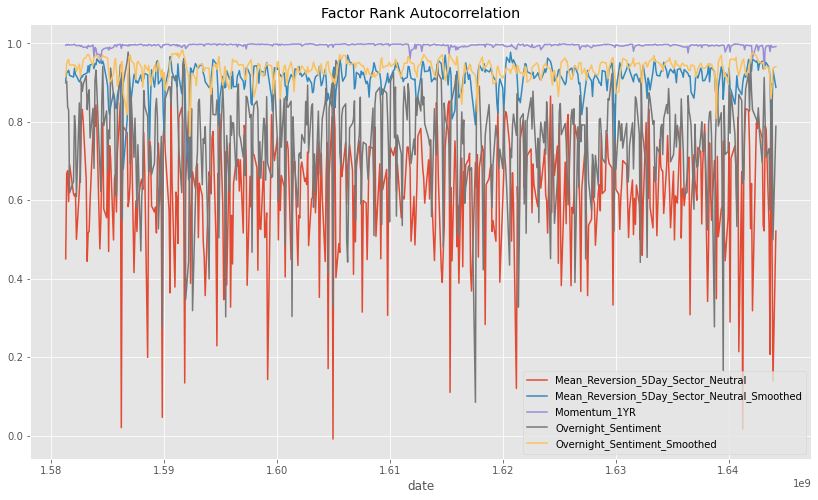

In [39]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

plt.figure(figsize=(15,10))
ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [40]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    #TODO: Implement function

    df_sharpe = pd.Series(data=annualization_factor*factor_returns.mean()/factor_returns.std())
    return df_sharpe


project_tests.test_sharpe_ratio(sharpe_ratio)

Tests Passed


### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [41]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral            0.38000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed   0.22000000
Momentum_1YR                                  0.69000000
Overnight_Sentiment                           0.25000000
Overnight_Sentiment_Smoothed                  0.96000000
dtype: float64

## Question: What do you think would happen if we smooth the momentum factor? Would the performance increase, decrease, or no major change? Why?

_#TODO: Put Answer In this Cell_

**Answer:** 

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [42]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(0 [A]),-0.07174743
Equity(1 [AA]),0.43047044
Equity(2 [AAL]),-0.79236230
Equity(3 [AAPL]),0.57372441
Equity(4 [ABBV]),-0.19281409


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [43]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """

        raise NotImplementedError(obj)

    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """

        raise NotImplementedError()

    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)

    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)

        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)

        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()

        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

If you have this sort of problem

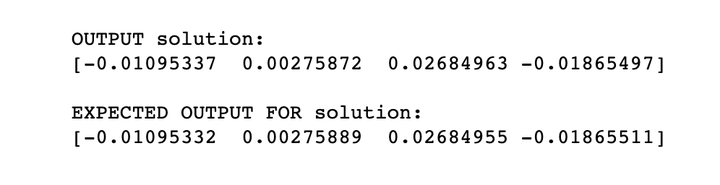

Upgrade the numpy by typing the below command onto jupyter notebook as;

!pip install -U numpy==1.14.5

In [44]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        obj = cvx.Minimize(
            -1 * alpha_vector.values.flatten() @ weights
        )
        
        return obj
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        #TODO: Implement function
        exposure = cvx.matmul(factor_betas.T, weights)
        constraints = [risk <= self.risk_cap,
                       exposure >= self.factor_min,
                       exposure <= self.factor_max,
                       cvx.sum(weights) == 0.,
                       sum(cvx.abs(weights))<=1.,
                       weights >= self.weights_min,
                       weights <= self.weights_max]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


project_tests.test_optimal_holdings_get_obj(OptimalHoldings)
project_tests.test_optimal_holdings_get_constraints(OptimalHoldings)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed

Running Integration Test on Problem.solve:
> x = np.diag(np.arange(3))
> s = np.diag(np.arange(4))
> factor_betas = np.arange(4 * 3).reshape([4, 3])
> risk = cvx.quad_form(weights * factor_betas, x) + cvx.quad_form(weights, s)
> constaints = optimal_holdings._get_constraints(weights, factor_betas, risk)
> obj = cvx.Maximize([0, 1, 5, -1] * weights)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()



AssertionError: Wrong value for solve_problem.

INPUT weights:
var113

OUTPUT solution:
[-0.04898471  0.01233806  0.12007483 -0.08342819]

EXPECTED OUTPUT FOR solution:
[-0.01095332  0.00275889  0.02684955 -0.01865511]


### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

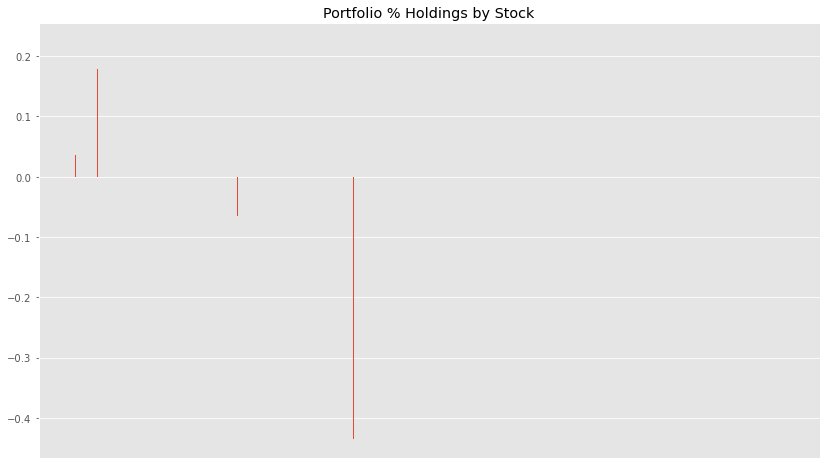

In [45]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Yikes. It put most of the weight in a few stocks.

<AxesSubplot:title={'center':'Portfolio Net Factor Exposures'}>

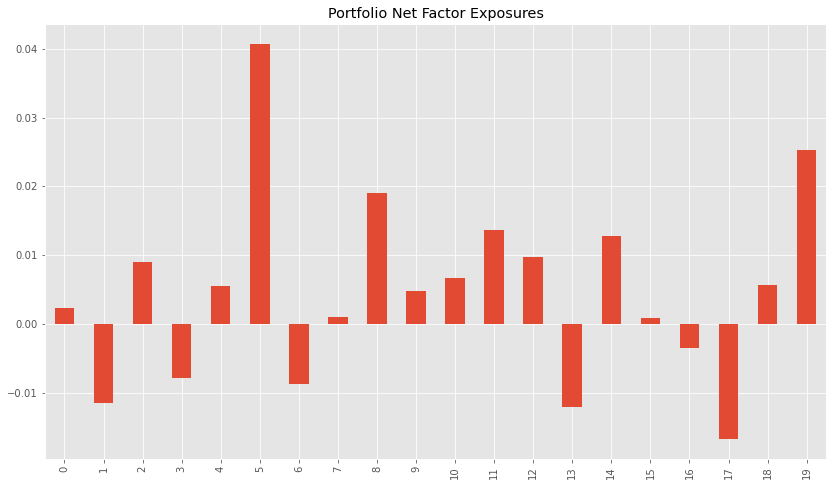

In [46]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [47]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        obj = cvx.Minimize(
            -1 * alpha_vector.values.flatten() @ weights + self.lambda_reg * cvx.norm2(weights)
        )
        
        return obj

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

project_tests.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_regualization._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


### View Data

C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\lunar\anaconda3\envs\p36env\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


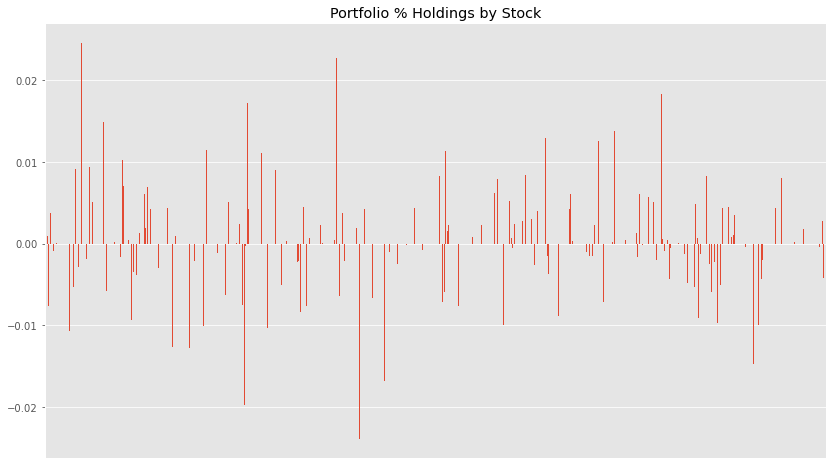

In [48]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

Nice. Well diversified.

<AxesSubplot:title={'center':'Portfolio Net Factor Exposures'}>

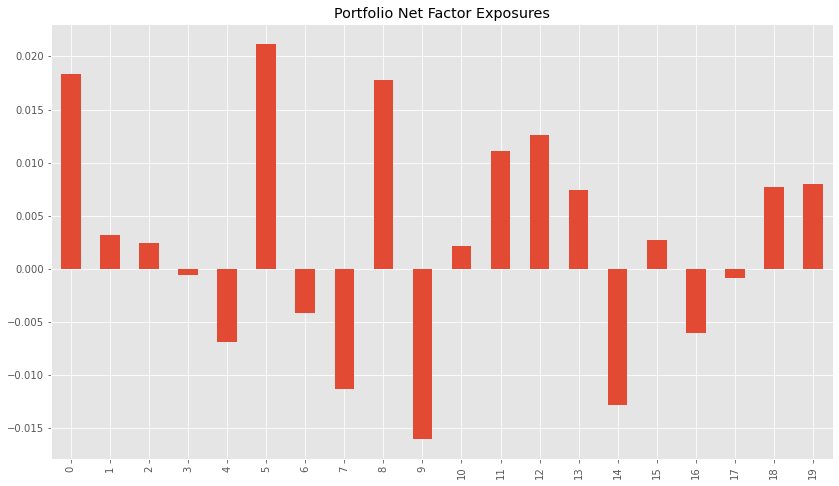

In [49]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [50]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        x = [-0.01095332, 0.00275889, 0.02684955, -0.01865511]

        #TODO: Implement function
        obj = cvx.Minimize(
            cvx.norm2(weights - (-1 * alpha_vector.values.flatten() @ weights))
        )
        
        return obj


project_tests.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()



AssertionError: Wrong value for solve_problem.

INPUT weights:
var19710

INPUT alpha_vector:
                  alpha_vector
Equity(0 [A])      -0.58642457
Equity(1 [AA])     -0.45333845
Equity(2 [AAL])    -0.69993898
Equity(3 [AAPL])   -0.06790952

OUTPUT solution:
[0. 0. 0. 0.]

EXPECTED OUTPUT FOR solution:
[-0.07441958 -0.00079418 -0.13721759  0.21243135]


### View Data

In [ ]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [ ]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.